# Deep Learning-Based Compressed Sensing under IQ Imbalance For Channel Estimation of mmWave Phased Arrays
- Institution: TU Delft
- Faculty: Mechanical Engineering
- Authors: Tom Lijding and Daan van Haasteren

### Python and Package Versions
- Python: 3.11.11
- Numpy: 2.2.1
- Scipy: 1.15.0
- Matplotlib: 3.10.0
- Pytorch: 2.5.1

### Introduction
This code demonstrates the use of a autoencoder based compressed sensing algorithm in channel estimation under IQ imbalance. We refer the reader to the file "Data_Compression_Deep_Learning_based_CS_under_IQ_Imbalance.pdf" for a full report and nice visuals!

### Structure
The code is structured as follows. First, the dataset is built upon which we train the neural networks. Next we create the neural networks i.e. build the custom layer "ComplexUnitModulus" which functions as the encoding layer, and build the architecture of the autoencoders via the Pytorch framework. We then define a standard function to train the neural networks which we use for the rest of the code. We train models for varying parameters i.e. SNR, IQ imbalance and encoding dimensions in that order. We then validate the models on a new training set and plot the results. We then define a new function to train models for limited resolution phased-array antennas, train a set of models and validate those as well. We finish with some code snippets to visualize the reconstruction of the original signal for a given model.

In [14]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random
import cmath
import math
plt.rcParams.update(plt.rcParamsDefault)

# Section 1: Building the dataset
In this section we build the dataset by generating a set of $K=10000$ random vectors of size $N=100$ with a range of sparsities. Currently, this is set to $7-9$ but these can range from $3-30$. The datasets are made by taking the DFT of these random vectors, thus making the resulting dataset dense! Following this, the vectors are tensorized for the Pytorch architecture and segmented for Epoch training.

### Define our buildDataSet function here!

In [15]:
def buildDataSet(max_amplitude, min_sparsity, max_sparsity, vector_size, data_set_size):
    sparse_data = np.zeros((vector_size, data_set_size), dtype=float)  # Ensure float type
    
    # Iterate over the columns of the sparse_data matrix to define the data samples
    for i in range(data_set_size):
        sparsity = random.randint(min_sparsity, max_sparsity)
        indices = random.sample(range(vector_size), sparsity)
        amps = np.random.uniform(-max_amplitude, max_amplitude, sparsity)  # Use negative and positive values
        sparse_data[indices, i] = amps
    
    # Define the DFT matrix and multiply our sparse_data vectors with it to find dense data
    DFT = sp.linalg.dft(vector_size) / np.sqrt(vector_size)
    dense_data = DFT @ sparse_data
    
    return dense_data, sparse_data


### Build the dataset

In [16]:
max_amplitude = 100
min_sparsity = 7
max_sparsity = 9
vector_size = 100
data_set_size = 10000
dense_data, sparse_data = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size)


### Test the dataset (optional)

In [17]:
DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
iDFT = DFT.conj().T

# Check if the iDFT of the dense data is in fact sparse, should be nearly all zeros
# print(iDFT@dense_data)


From the above results, we can see that our vectors are very sparse if we take the IDFT

### Setting up the dataset for Pytorch

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.init as init

# Generate dataset
def Generate_Dataloader(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size):
    # Function takes as inputs the (maximum) amplitude of the signal, minimum and maximum sparsity of the signal, the signal length (vector_size) and the size of the dataset
    # Outputs dataloader and signal variance, which is important for normalization
    dense_data, sparse_data = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size)

    X = np.concatenate((dense_data.real,dense_data.imag)).T
    Y = np.concatenate((dense_data.real,dense_data.imag)).T

    X_tensor = torch.tensor(X,dtype=torch.float)
    Y_tensor = torch.tensor(Y,dtype=torch.float)
    dataset = TensorDataset(X_tensor,Y_tensor)

    dataloader = DataLoader(dataset,batch_size = 500,shuffle = True, )
    variance = np.var(Y)
    return dataloader, variance

dataloader, signal_variance = Generate_Dataloader(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size)


### Creating a function to validate our models
This function serves to take in a dataset and a model and gives us the loss of the model on that dataset

In [19]:
def validateModels(dataloader,models,loss_fn,signal_variance=133):
    models_losses = []
    with torch.no_grad():
        for model in models:
            current_model_losses = []
            model.eval()
            for batch in dataloader:
                inputs, targets = batch  # Unpack the tuple
                output = model(inputs)
                loss = loss_fn(output, targets)
                current_model_losses.append(loss.item())
            models_losses.append(np.average(current_model_losses))

    models_losses = np.array(models_losses)
    normalized_models_losses = models_losses/signal_variance
    return normalized_models_losses,models_losses

### Create a visualization function
This function takes in a model which we have built, generates an input vector, runs it through the model and plots the input and output vectors

In [20]:
def visualizeReconstruction(model,max_amplitude=100,min_sparsity=3,max_sparsity=5,vector_size=100):
    h, x = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,1)

    H = np.concatenate((h.real,h.imag)).T

    H_tensor = torch.tensor(H,dtype=torch.float)

    H_hat = model(H_tensor)

    h_hat = np.array(H_hat.detach())

    h_real,h_imag = np.split(h_hat,2,1)
    h_hat = h_real + 1j*h_imag
    h_hat = h_hat.reshape(-1,1)
    DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
    iDFT = DFT.conj().T

    x_hat = iDFT@h_hat
    indices = range(len(x_hat))

    plt.vlines(indices,0,x,linewidth=3)
    plt.vlines(indices,0,x_hat,colors="orange")

    plt.legend(("x","x_hat"))

# Section 2: Building the neural network architecture
In this section we actually build the neural network architecture! We define a custom layer, namely ComplexUnitModulus, to be able to fulfill the physical restrictions of the phased-array antenna. We refer the interested reader to our paper for more on how this is done!

## Setting up the Neural Networks

In [8]:

def complex_xavier_init(tensor_real, tensor_imag, gain=1.0):
    # Apply Xavier initialization (using uniform variant) to both real and imaginary parts
    # If we do not do this the neural network initializes at a *very* bad initial point and we get terrible convergence
    # Only applicable for the ComplexLinear layer
    init.xavier_uniform_(tensor_real, gain=gain)
    init.xavier_uniform_(tensor_imag, gain=gain)

class ComplexUnitModulus(nn.Module):
    # This class serves as the encoder layer. We are restricted to values which are of the form e^jq where q are trainable parameters
    # Notice that the input and output dimensions are half of what the actual vector size is! Because it is a complex value, our dimensions are twice as long
    def __init__(self,input_dim,output_dim):
        super(ComplexUnitModulus,self).__init__()
        # Here we create the q-values of our unitary matrix. These are the parameters we are training such that each entry of our complex matrix to encode our data is |F_ij| = 1
        self.q_values = nn.Parameter(torch.randn(output_dim,input_dim))

    def forward(self,x):   
        # Compute unitary weights dynamically in each forward pass
        W_real = torch.cos(self.q_values)
        W_imag = torch.sin(self.q_values)
        W_top = torch.cat([W_real, -W_imag], dim=1)  # [W_real, -W_imag]
        W_bottom = torch.cat([W_imag, W_real], dim=1)  # [W_imag, W_real]
        W_total = torch.cat([W_top, W_bottom], dim=0)  # Stack rows to form the full matrix 
        out = torch.matmul(x,W_total.T)
        return out
    
class ComplexLinear(nn.Module):
    # This custom layer was found to work less well than a regular linear layer, probably because we put restrictions on the network allowing it to be less expressive.
    # Notice that the input and output dimensions are half of what the actual vector size is! Because it is a complex value, our dimensions are twice as long. This gets fixed because we make the matrix
    # W_total which multiplies [x_real;x_imag] and returns [y_real;y_imag]
    def __init__(self,input_dim,output_dim):
        super(ComplexLinear,self).__init__()
        # Here we create the complex matrix W
        #self.W_real = nn.Parameter(torch.randn(output_dim,input_dim))# eye(input_dim))
        #self.W_imag = nn.Parameter(torch.randn(output_dim,input_dim)) #zeros((input_dim,output_dim)))

        self.W_real = nn.Parameter(torch.empty(output_dim, input_dim))
        self.W_imag = nn.Parameter(torch.empty(output_dim, input_dim))
        self.reset_parameters()
    
    def reset_parameters(self):
        # Initialize both the real and imaginary parts using Xavier initialization.
        complex_xavier_init(self.W_real, self.W_imag)
        
    def forward(self,x):   
        # Compute unitary weights dynamically in each forward pass
        W_real = self.W_real
        W_imag = self.W_imag
        W_top = torch.cat([W_real, -W_imag], dim=1)  # [W_real, -W_imag]
        W_bottom = torch.cat([W_imag, W_real], dim=1)  # [W_imag, W_real]
        W_total = torch.cat([W_top, W_bottom], dim=0)  # Stack rows to form the full matrix 
        out = torch.matmul(x,W_total.T)
        return out

class LearnedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim,hidden_dims):
        super(LearnedAutoencoder, self).__init__()

        self.encoder = ComplexUnitModulus(input_dim,encoding_dim)
        layers = []
        prev_dim = encoding_dim*2
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim,dim*2))
            layers.append(nn.ReLU())
            prev_dim = dim*2
        self.decoder = nn.Sequential(
            *layers,
            nn.Linear(prev_dim,input_dim*2)
        )

    def forward(self, x):
        encoder_out = self.encoder(x)

        return self.decoder(encoder_out)
    
class LearnedAutoencoderWithNoise(nn.Module):
    def __init__(self, input_dim, encoding_dim,hidden_dims,variance):
        super(LearnedAutoencoderWithNoise, self).__init__()
        self.variance = variance
        self.encoder = ComplexUnitModulus(input_dim,encoding_dim)
        self.encoding_dim = encoding_dim
        layers = []
        prev_dim = encoding_dim*2
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim,dim*2))
            layers.append(nn.ReLU())
            prev_dim = dim*2
        self.decoder = nn.Sequential(
            *layers,
            nn.Linear(prev_dim,input_dim*2)
        )

    def forward(self,x):
        encoder_out = self.encoder(x)
        noise_np = np.random.normal(0,self.variance,size=self.encoding_dim*2)
        noise = torch.tensor(noise_np,dtype=torch.float)
        noisy_y = encoder_out + noise
        return self.decoder(noisy_y)

# It should be noted that all previous autoencoders are less general versions of this neural network architecture. 
# If we set the IQ imbalance to 0 and the SNR to inf(), then we get previous architectures
class LearnedAutoencoderWithIQImbalance(nn.Module):
    def __init__(self, input_dim, encoding_dim,hidden_dims,b, d,variance):
        super(LearnedAutoencoderWithIQImbalance, self).__init__()
        self.encoder = ComplexUnitModulus(input_dim,encoding_dim)
        self.encoding_dim = encoding_dim
        self.variance = variance
        self.r = torch.tensor(0.5*(1+b*np.exp(1j*d)), dtype=torch.complex64)
        layers = []
        prev_dim = encoding_dim*2
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim,dim*2))
            layers.append(nn.ReLU())
            prev_dim = dim*2
        self.decoder = nn.Sequential(
            *layers,
            nn.Linear(prev_dim,input_dim*2)
        )

    def forward(self,x):
        encoder_out = self.encoder(x)
        y_real = encoder_out[:, :self.encoding_dim]
        y_imag = encoder_out[:, self.encoding_dim:]
        y = torch.complex(y_real,y_imag)
        yiq = self.r * y + (1-self.r.conj()) * (y.conj())
        yiqr = yiq.real
        yiqi = yiq.imag
        yiqstack = torch.cat((yiqr,yiqi),dim=1)
        noise_np = np.random.normal(0,self.variance,size=self.encoding_dim*2)
        noise_tensor = torch.tensor(noise_np,dtype=torch.float)
        y_iq_stack_noisy = yiqstack + noise_tensor
        return self.decoder(y_iq_stack_noisy)

# Section 3: Training the models
In this section we train the models. The models are trained for varying SNR, IRR and measurement sizes, in that order. The ranges for how these models were trained are

$$SNR \in \{2,5,8,11,14,17,20\}$$
$$IRR \in \{41.09,33.12, 23.53, 17.43, 12.85\}$$
$$M \in \{5, 10, 20, 30, 40, 50\}$$

### Define function for training the models

In [9]:
def trainModels(dataloader,SNR_values,imb_percentages,encoding_dims,epochs,signal_variance = 133,hidden_dims=[60,80]):
    # Function takes as inputs:
    # dataloader: The dataloader object of the training data set
    # SNR_values: Signal to noise ratios
    # imb_percentages: imbalance percentages
    # encoding_dims: Encoding dimensions
    # epochs: Maximum amount of epochs we want the model to run for
    # signal_variance: The variance of the original signal
    # hidden_dims: Hidden dimensions for the neural network
    # Returns the best model with corresponding MSELoss
    models = []
    for model_num,(SNR,imb_percentage,encoding_dim) in enumerate(zip(SNR_values,imb_percentages,encoding_dims)):
        abs_noise_ratio = 10**(SNR/10)
        variance = signal_variance/abs_noise_ratio
        b = 1 - (0.2 * imb_percentage)
        d = imb_percentage * np.pi/8
        hidden_dims = np.array([60,80])
        current_training_model = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
        optimizer = torch.optim.Adam(current_training_model.parameters(), lr=1E-3, betas=(0.9,0.999))
        MSEloss_fn = nn.MSELoss()

        # Training loop
        losses = []
        lowest_loss = float("inf")
        for epoch in range(epochs):
            for batch in dataloader:
                inputs, targets = batch  # Unpack the tuple
                optimizer.zero_grad()
                output = current_training_model(inputs)
                loss = MSEloss_fn(output, targets)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
            if loss< lowest_loss:
                lowest_loss = loss
                early_stopping_counter = 0
                best_model = current_training_model
            else:
                early_stopping_counter += 1
                if early_stopping_counter > 100:
                    current_training_model = best_model
                    print(f"Stopped early after {epoch+1} epochs, with loss of {lowest_loss:.6f}")
                    break
            print(f"SNR:{SNR}, Imbalance Percentage:{imb_percentage}, Encoding dimension:{encoding_dim}, Epoch {epoch+1}, Loss: {loss.item():.6f}")
        models.append(best_model)
        losses.append(lowest_loss)
    return models, losses

### Train Noisy Models
Here is code to train a range of noisy models. The commented code allows us to train the full range of noisy models, while for illustration purposes we have only uncommented code which trains a single model for 100 epochs

#### Extra specifications
- IRR: $\infty$
- Encoding dimensions: 50
- Maximum epoch iteration: 10000
- Stop after how many epochs of no loss improvement: 100

In [20]:
# We define our signal to noise ratio as ranging from 2 to 20 dB

# Train full range of models
# SNR_list = [2,5,8,11,14,17,20]
# imb_percentages = [0,0,0,0,0,0,0]
# encoding_dims = [50,50,50,50,50,50,50]
# epochs = 10000

# Train one model for illustration purposes
SNR_list = [20]
imb_percentage_list = [0]
encoding_dim_list = [50]
epochs = 100

dataloader, signal_var = Generate_Dataloader(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size)

noisy_models, noisy_losses = trainModels(dataloader,SNR_list,imb_percentage_list,encoding_dim_list,epochs,signal_variance=signal_var)

SNR:20, Imbalance Percentage:0, Encoding dimension:50, Epoch 1, Loss: 133.210083
SNR:20, Imbalance Percentage:0, Encoding dimension:50, Epoch 2, Loss: 128.447128
SNR:20, Imbalance Percentage:0, Encoding dimension:50, Epoch 3, Loss: 120.921356
SNR:20, Imbalance Percentage:0, Encoding dimension:50, Epoch 4, Loss: 107.568443
SNR:20, Imbalance Percentage:0, Encoding dimension:50, Epoch 5, Loss: 93.800636
SNR:20, Imbalance Percentage:0, Encoding dimension:50, Epoch 6, Loss: 80.348854
SNR:20, Imbalance Percentage:0, Encoding dimension:50, Epoch 7, Loss: 72.723625
SNR:20, Imbalance Percentage:0, Encoding dimension:50, Epoch 8, Loss: 66.178024
SNR:20, Imbalance Percentage:0, Encoding dimension:50, Epoch 9, Loss: 61.408901
SNR:20, Imbalance Percentage:0, Encoding dimension:50, Epoch 10, Loss: 57.104164
SNR:20, Imbalance Percentage:0, Encoding dimension:50, Epoch 11, Loss: 54.422577
SNR:20, Imbalance Percentage:0, Encoding dimension:50, Epoch 12, Loss: 51.723354
SNR:20, Imbalance Percentage:0, E

### Save the Noisy Models (DO NOT RUN)
This will replace the existing models with (potentially) empty and/or untrained models)

In [21]:
# for indx, (db, value) in enumerate(SNR.items()):
#     torch.save(noisy_models[indx].state_dict(), f"Models/noisy_models/sparsity_{min_sparsity}-{max_sparsity}/noisy_model_{db}_{min_sparsity}-{max_sparsity}.pt")

### Train the IQ imbalanced models

##### Extra specifications
- SNR: $\infty$
- Encoding dimensions: 50
- Maximum epoch iteration: 10000
- Stop after how many epochs of no loss improvement: 100

In [22]:
# Train full range of IQ imbalances

# SNR_list = [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]
# imb_percentage_list = [0, 0.04, 0.1, 0.3, 0.6, 1]
# encoding_dim_list = [50, 50, 50, 50, 50, 50]
# epochs = 10000

# Train one model for illustration purposes
SNR_list = [np.inf]
imb_percentage_list = [0.6]
encoding_dim_list = [50]
epochs = 100

dataloader, signal_var = Generate_Dataloader(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size)

imbalanced_models, imbalanced_losses = trainModels(dataloader,SNR_list,imb_percentage_list,encoding_dim_list,epochs,signal_variance=signal_var)

SNR:inf, Imbalance Percentage:0.6, Encoding dimension:50, Epoch 1, Loss: 131.753998
SNR:inf, Imbalance Percentage:0.6, Encoding dimension:50, Epoch 2, Loss: 127.246040
SNR:inf, Imbalance Percentage:0.6, Encoding dimension:50, Epoch 3, Loss: 121.921494
SNR:inf, Imbalance Percentage:0.6, Encoding dimension:50, Epoch 4, Loss: 107.887123
SNR:inf, Imbalance Percentage:0.6, Encoding dimension:50, Epoch 5, Loss: 92.138519
SNR:inf, Imbalance Percentage:0.6, Encoding dimension:50, Epoch 6, Loss: 85.894653
SNR:inf, Imbalance Percentage:0.6, Encoding dimension:50, Epoch 7, Loss: 74.410950
SNR:inf, Imbalance Percentage:0.6, Encoding dimension:50, Epoch 8, Loss: 71.592247
SNR:inf, Imbalance Percentage:0.6, Encoding dimension:50, Epoch 9, Loss: 64.756889
SNR:inf, Imbalance Percentage:0.6, Encoding dimension:50, Epoch 10, Loss: 62.256546
SNR:inf, Imbalance Percentage:0.6, Encoding dimension:50, Epoch 11, Loss: 59.046310
SNR:inf, Imbalance Percentage:0.6, Encoding dimension:50, Epoch 12, Loss: 54.7006

### Save the IQ imbalanced models (DO NOT RUN)


In [23]:
# Calculate the dB imbalance levels, we store them in the dictionary IRR_ratios such that we can extract it with the corresponding level imbalance
imb_percentage_list = [0, 0.04, 0.1, 0.3, 0.6, 1]
IRR_ratios = {}
for level in imb_percentage_list:
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    r = 0.5*(1+b*np.exp(1j*d))
    IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)
    IRR_ratios[level] = 10*np.log10(IRR_ratio)

# Uncomment to save
# for indx, items in enumerate(IRR_ratios):
#     torch.save(imbalanced_models[indx].state_dict(), f"Models/imbalanced_models/sparsity_{min_sparsity}-{max_sparsity}/imbalanced_model_{items:.3f}_{min_sparsity}-{max_sparsity}.pt")

/tmp/ipykernel_14740/4109955618.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)


### Train the models for varying encoding dimensions (i.e. measurement sizes)
##### Extra specifications
- IRR: $\infty$
- SNR: $\infty$
- Maximum epoch iteration: 10000
- Stop after how many epochs of no loss improvement: 100

In [24]:
# Train full range of IQ imbalances

# SNR_list = [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]
# imb_percentage_list = [0, 0, 0, 0, 0, 0]
# encoding_dim_list = [5, 10, 20, 30, 40, 50]
# epochs = 10000

# Train one model for illustration purposes
SNR_list = [np.inf]
imb_percentage_list = [0]
encoding_dim_list = [30]
epochs = 100

dataloader, signal_var = Generate_Dataloader(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size)

measurement_models, measurement_losses = trainModels(dataloader,SNR_list,imb_percentage_list,encoding_dim_list,epochs,signal_variance=signal_var)

SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 1, Loss: 131.432526
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 2, Loss: 127.384216
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 3, Loss: 124.880737
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 4, Loss: 115.207840
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 5, Loss: 103.657600
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 6, Loss: 92.493629
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 7, Loss: 87.499939
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 8, Loss: 83.772461
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 9, Loss: 78.199371
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 10, Loss: 72.957916
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 11, Loss: 71.294250
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 12, Loss: 69.085732
SNR:inf, Imbalance P

### Save the models for varying encoding dimensions (DO NOT RUN)

In [25]:
# for indx, encoding_dim in enumerate(encoding_dim_list):
#     torch.save(measurement_models[indx].state_dict(), f"Models/measurement_models/sparsity_{min_sparsity}-{max_sparsity}/measurement_model_{encoding_dim}_{min_sparsity}-{max_sparsity}.pt")

# Section 4: Initializing and validating pretrained models
In this section we initialize all of the pretrained models and validate on a new dataset! Note that we have trained until now over $(6+5+7) \cdot 4 = 72$ models!

### Initializing pretrained models
Here we initialize all of our pretrained models. 

In [26]:
sparsity_ranges = [(3, 5), (5, 7), (7, 9), (10, 30)]
measurement_sizes = [5, 10, 20, 30, 40, 50]
# Define the SNR dictionary for use
db_list = [2,5,8,11,14,17,20]
signal_variance = 133 # Found by measuring empirically what the variance of the signal is once transformed from sparse signal
SNR = {}

# Then define the absolute values of the SNR ratio
for db_ratio in db_list:
    SNR[db_ratio] = 10**(db_ratio/10)

imb_percentage_list = [0, 0.04, 0.1, 0.3, 0.6, 1]
IRR_ratios = {}
for level in imb_percentage_list:
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    r = 0.5*(1+b*np.exp(1j*d))
    IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)
    IRR_ratios[level] = 10*np.log10(IRR_ratio)

#empty dicts to store models in
noisy_pretrained_models = {}
imbalanced_pretrained_models = {}
measurement_pretrained_models = {}


for i, (min_spars, max_spars) in enumerate(sparsity_ranges):

    #Initialize pretrained noisy models
    for db,abs in SNR.items():
        encoding_dim = 50
        variance = signal_variance/abs
        # Initialize model
        hidden_dims = np.array([60,80])
        noisy_pretrained_models[(i, db)] = LearnedAutoencoderWithNoise(vector_size,encoding_dim,hidden_dims,variance)
        noisy_pretrained_models[(i, db)].load_state_dict(torch.load(f"Models/noisy_models/sparsity_{min_spars}-{max_spars}/noisy_model_{db}_{min_spars}-{max_spars}.pt", weights_only=True))

    # Initialize pretrained imbalanced_models
    for level, db  in IRR_ratios.items():
        encoding_dim = 50
        variance = 0
        b = 1 - (0.2 * level)
        d = level * np.pi/8
        # Initialize model
        hidden_dims = np.array([60,80])
        imbalanced_pretrained_models[(i, level)] = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
        imbalanced_pretrained_models[(i, level)].load_state_dict(torch.load(f"Models/imbalanced_models/sparsity_{min_spars}-{max_spars}/imbalanced_model_{level:.3f}_{min_spars}-{max_spars}.pt", weights_only=True))

    # Initialize pretrained measurement models
    for encoding_dim  in measurement_sizes:
        variance = signal_variance/SNR[17]
        level = 0.6
        b = 1 - (0.2 * level)
        d = level * np.pi/8
        # Initialize model
        hidden_dims = np.array([60,80])
        measurement_pretrained_models[(i, encoding_dim)] = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
        measurement_pretrained_models[(i, encoding_dim)].load_state_dict(torch.load(f"Models/measurement_models/sparsity_{min_spars}-{max_spars}/measurement_model_{encoding_dim}_{min_spars}-{max_spars}.pt", weights_only=True))




/tmp/ipykernel_14740/3281787765.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)


In [27]:

all_noisy_losses = []
all_imbalanced_losses = []
all_measurement_losses = []

loss_fn = nn.MSELoss()

for i, (min_spars, max_spars) in enumerate(sparsity_ranges):
    dataloader_val, signal_variance = Generate_Dataloader(max_amplitude, min_spars, max_spars, vector_size, data_set_size)
    # Evaluate noisy models
    noisy_val_losses = []
    noisy_model_losses = []
    with torch.no_grad():
        for db, abs in SNR.items():
            noisy_model = noisy_pretrained_models[(i, db)]
            noisy_model.eval()
            for batch in dataloader_val:
                inputs, targets = batch  # Unpack the tuple
                output = noisy_model(inputs)
                loss = loss_fn(output, targets)
                noisy_model_losses.append(loss.item())
            noisy_val_losses.append(np.average(noisy_model_losses))
            noisy_model_losses = []

    noisy_val_losses = np.array(noisy_val_losses)
    normalized_noisy_val_losses = noisy_val_losses/signal_variance
    all_noisy_losses.append(normalized_noisy_val_losses)

    # Evaluate Imbalanced models
    imbalance_model_losses = []
    imbalance_val_losses = []

    with torch.no_grad():
        for level, db in IRR_ratios.items():
            imbalance_model = imbalanced_pretrained_models[(i, level)]
            imbalance_model.eval()
            for batch in dataloader_val:
                inputs, targets = batch  # Unpack the tuple
                output = imbalance_model(inputs)
                loss = loss_fn(output, targets)
                imbalance_model_losses.append(loss.item())
            imbalance_val_losses.append(np.average(imbalance_model_losses))
            imbalance_model_losses = []

    imbalance_val_losses = np.array(imbalance_val_losses)
    normalized_imbalance_val_losses = imbalance_val_losses/signal_variance
    all_imbalanced_losses.append(normalized_imbalance_val_losses)

    # Evaluate models with varying measurement sizes
    measurement_model_losses = []
    measurement_val_losses = []

    with (torch.no_grad()):
        for encoding_dim in measurement_sizes:
            measurement_model = measurement_pretrained_models[(i, encoding_dim)]
            measurement_model.eval()
            for batch in dataloader_val:
                inputs, targets = batch  # Unpack the tuple
                output = measurement_model(inputs)
                loss = loss_fn(output, targets)
                measurement_model_losses.append(loss.item())
            measurement_val_losses.append(np.average(measurement_model_losses))
            measurement_model_losses = []

    measurement_val_losses = np.array(measurement_val_losses)
    normalized_measurement_val_losses = measurement_val_losses/signal_variance
    all_measurement_losses.append(normalized_measurement_val_losses)


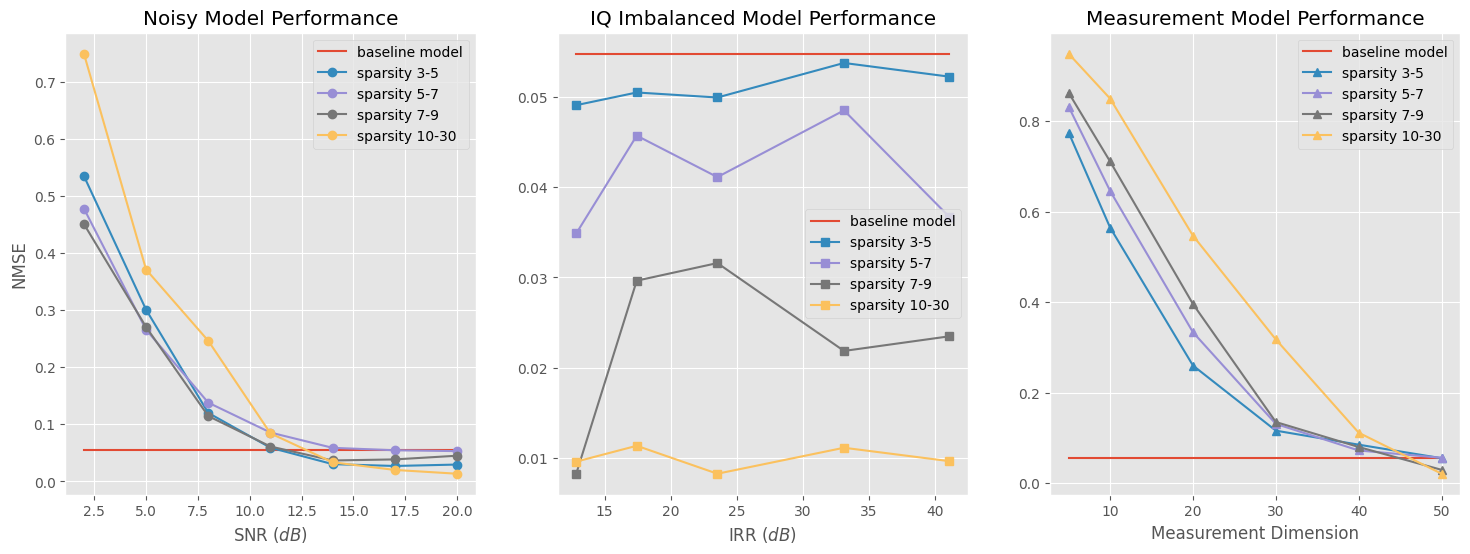

In [28]:
plt.style.use('ggplot')
fig1, (ax1, ax2, ax3) = plt.subplots(ncols=3,nrows = 1,figsize=(18, 6))

for i in range(4):
    if i==0:
        noiseless_loss = all_imbalanced_losses[0][0]
        ax1.plot(SNR.keys(), [noiseless_loss for i in SNR.keys()])
        ax2.plot(IRR_ratios.values(), [noiseless_loss for i in IRR_ratios.values()])
        ax3.plot(measurement_sizes, [noiseless_loss for i in measurement_sizes])

    ax1.plot(SNR.keys(), all_noisy_losses[i], marker="o")
    ax1.set_xlabel("SNR $(dB)$")
    ax1.set_ylabel("NMSE")
    ax1.set_title("Noisy Model Performance")
    ax1.grid(True)
    ax1.legend(["baseline model", "sparsity 3-5", "sparsity 5-7","sparsity 7-9", "sparsity 10-30"])

    ax2.plot(IRR_ratios.values(),all_imbalanced_losses[i],marker='s')
    ax2.set_xlabel("IRR $(dB)$")
    ax2.set_title("IQ Imbalanced Model Performance")
    ax2.legend(["baseline model", "sparsity 3-5","sparsity 5-7","sparsity 7-9", "sparsity 10-30"])
    ax2.grid(True)

    ax3.plot(measurement_sizes, all_measurement_losses[i],marker='^')
    ax3.set_xlabel("Measurement Dimension")
    ax3.set_title("Measurement Model Performance")
    ax3.legend(["baseline model", "sparsity 3-5","sparsity 5-7","sparsity 7-9", "sparsity 10-30"])
    ax3.grid(True)

plt.show()

# Section 5: Training limited resolution phased-array antenna setup
In this section we train new models for a limited resolution phased-array antenna setup. We restrict ourselves to a 5-bit setup, ranging from

$$q \in \{-\pi,-\frac{1}{2}\pi,0,\frac{1}{2}\pi,\pi\}$$

Note that of course this setup can be changed to any resolution, as the loss function is adjustable for any amount of zero's. We define a new loss function to regularize the optimization to prefer values of $q$ close to the defined range. The regularization term is defined as

$$g(q) = \lvert q(q-\frac{\pi}{2})(q-\pi)(q+\frac{\pi}{2})(q+\pi)\rvert$$

As we were not sure this approach would work, we show in this section a more detailed walk through of the process by showing the loss function, as well as the values of the CS matrix before mapping to discrete values.

Loss function shown graphically below.

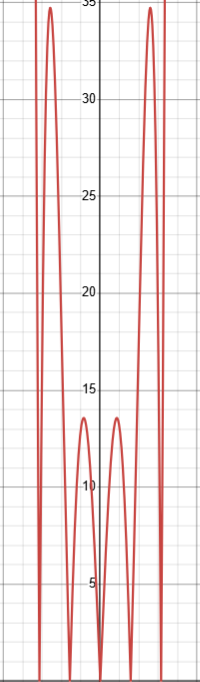

## Section 5.1: Testing
In this section we test the new loss function and see if it works on the easiest case (noiseless, no IQ imbalance and encoding dimensions equal to 50).

### Create new loss function
This function is used in the Pytorch framework to drive the values of the measurement matrix to discrete values $\{-\pi,-\frac{1}{2}\pi,0,\frac{1}{2}\pi,\pi\}$

In [29]:
def discreteLossPoly(qweights,scaleFactor):
    loss = 0
    pi = torch.tensor(math.pi)
    # Note that we need to flatten the weights so that our iteration does not result in us iterating over the rows instead of the weights
    qVec = qweights.flatten()
    # Efficient implementation of the loss function, by doing vector operations, saves a lot of time in training
    loss += torch.linalg.vector_norm(qVec*(qVec-1/2*pi)*(qVec-1*pi)*(qVec+pi)*(qVec+1/2*pi),1)
    loss = loss*scaleFactor # Scale the resulting loss
    return loss

## Train neural network using new loss function

Epoch 1, Loss: 2439.845947
Epoch 2, Loss: 2340.470459
Epoch 3, Loss: 2236.799561
Epoch 4, Loss: 2122.422363
Epoch 5, Loss: 2010.458496
Epoch 6, Loss: 1897.715820
Epoch 7, Loss: 1785.777466
Epoch 8, Loss: 1671.738525
Epoch 9, Loss: 1564.405273
Epoch 10, Loss: 1453.079712
Epoch 11, Loss: 1339.081909
Epoch 12, Loss: 1229.797363
Epoch 13, Loss: 1120.101440
Epoch 14, Loss: 1009.123352
Epoch 15, Loss: 904.063660
Epoch 16, Loss: 801.091858
Epoch 17, Loss: 703.465393
Epoch 18, Loss: 611.343750
Epoch 19, Loss: 523.938049
Epoch 20, Loss: 440.941895
Epoch 21, Loss: 365.676727
Epoch 22, Loss: 299.721832
Epoch 23, Loss: 248.758850
Epoch 24, Loss: 208.328842
Epoch 25, Loss: 171.505035
Epoch 26, Loss: 138.243866
Epoch 27, Loss: 111.460709
Epoch 28, Loss: 88.535843
Epoch 29, Loss: 73.150146
Epoch 30, Loss: 67.876450
Epoch 31, Loss: 62.805340
Epoch 32, Loss: 60.404129
Epoch 33, Loss: 56.271294
Epoch 34, Loss: 52.841766
Epoch 35, Loss: 51.122406
Epoch 36, Loss: 47.387039
Epoch 37, Loss: 46.550011
Epoch 

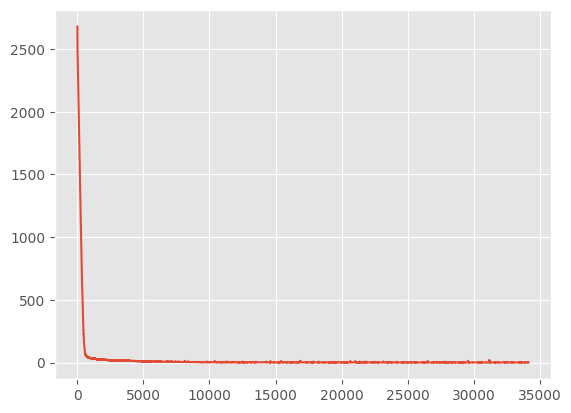

In [30]:
vector_size = 100
encoding_dim = 50
hidden_dims = np.array([60,80])
discrete_autoencoder_model = LearnedAutoencoder(vector_size,encoding_dim,hidden_dims)
optimizer = torch.optim.Adam(discrete_autoencoder_model.parameters(), lr=1E-3, betas=(0.9,0.999))
MSELossfn = nn.MSELoss()
scaleFactor = 0.05 # Hyperparameter, setting this too high causes the problem to not converge to low loss, due to the problem converging to discrete values too early, setting too low causes the
# values to not converge to discrete values. Empirical testing showed that scaleFactor of 0.05 was nice

# Training loop
losses = []
lowest_loss = float("inf")
for epoch in range(5000):
    for batch in dataloader:
        inputs, targets = batch  # Unpack the tuple
        optimizer.zero_grad()
        output = discrete_autoencoder_model(inputs)
        qweights = discrete_autoencoder_model.encoder.q_values
        loss = discreteLossPoly(qweights,scaleFactor) + MSELossfn(output,targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if loss < lowest_loss:
        lowest_loss = loss.item()
        early_stopping_counter = 0
        best_model = discrete_autoencoder_model
    else:
        early_stopping_counter += 1
        if early_stopping_counter > 100:
            discrete_autoencoder_model = best_model
            print(f"stopped early after {epoch+1} epochs, with a loss of: {lowest_loss}")
            break

    print(f"Epoch {epoch+1}, Loss: {lowest_loss:.6f}")

plt.plot(losses)
plt.show()

### Show the values of the weights, they should be $\{0,\pm1.57079,\pm3.14159\}$

Notice that in fact, the values are not exactly in the above set but they are quite close!

In [31]:
print(discrete_autoencoder_model.encoder.q_values[0:20,0:20])

tensor([[-1.5707e+00,  4.0283e-05, -1.5708e+00, -1.5708e+00, -1.0713e-04,
          1.3885e-04, -1.6476e-04,  3.1416e+00,  3.3499e-04,  7.5454e-05,
          1.1472e-04, -6.1352e-05, -3.7930e-06, -1.5750e-04, -5.2845e-05,
         -4.1358e-05, -1.1994e-04,  8.9084e-05, -1.5709e+00,  1.5706e+00],
        [ 4.5018e-04,  1.5707e+00,  1.7965e-04, -1.4673e-04, -2.2644e-04,
          2.2459e-04,  1.5706e+00,  1.5709e+00,  1.5708e+00, -1.0340e-04,
          1.6360e-04, -1.5710e+00, -1.5707e+00,  8.4664e-05,  2.5510e-04,
          8.1784e-05,  1.5706e+00, -7.6247e-05,  3.7239e-04,  3.4284e-05],
        [ 1.5708e+00, -2.2201e-04, -1.2829e-05,  3.9699e-04, -1.1036e-04,
         -4.0515e-05, -1.5705e+00, -1.5707e+00,  1.5708e+00, -1.5709e+00,
         -1.5708e+00, -1.5708e+00, -1.7423e-04, -4.2594e-05, -2.9945e-04,
          1.5709e+00,  2.4125e-04, -1.5709e+00,  2.8703e-05, -2.5356e-04],
        [ 1.0579e-05,  1.5709e+00,  1.5710e+00,  3.3842e-04,  1.5709e+00,
          3.0471e-05,  1.5707e+00, 

## Now we map all the values to actual discrete values

In [32]:
def mapToDiscreteValues(weights,discrete_values):
    # Input is a tensor (possibly a matrix) of weights, and a np array of discrete values
    discrete_values = discrete_values.flatten()
    weights_np = weights.detach().cpu().numpy() # Convert to numpy array
    shape = weights_np.shape
    weights_vector = np.reshape(weights_np,(-1,1)) # flatten the matrix to a vector such that subtracting from the discrete values results in a matrix!
    
    # Create a matrix of distances, then make a vector of indices from this matrix. Each value of the vector is the index of the closest discrete value
    distances = np.abs(weights_vector - discrete_values)
    indices = np.argmin(distances,1)

    # Map the weights to the closest discrete values and reshape into original matrix, and turn into a nn.Parameter object
    mappedWeights = discrete_values[indices]
    mappedWeights = np.reshape(mappedWeights,shape)
    mappedWeights = np.float32(mappedWeights) # Notice we map it to a float because that is what is used for our model
    mappedWeights = nn.Parameter(torch.from_numpy(mappedWeights))
    return mappedWeights

# Testing


In [33]:

qweights = discrete_autoencoder_model.encoder.q_values
discrete_values = np.array([-np.pi, -0.5*np.pi,0,0.5*np.pi,np.pi])
mapped_q_weights = mapToDiscreteValues(qweights,discrete_values)


mapped_discrete_autoencoder_model = discrete_autoencoder_model
mapped_discrete_autoencoder_model.encoder.q_values = mapped_q_weights


### Save the model (DO NOT RUN)
Again, will overwrite existing model with an empty model

In [34]:
# torch.save(mapped_discrete_autoencoder_model.state_dict(), f"Models/discrete_models/discrete_model.pt")

### Load discrete model

In [35]:
discrete_model = LearnedAutoencoder(vector_size,encoding_dim,hidden_dims)
# Load the state dictionary
discrete_model.load_state_dict(torch.load("Models/discrete_models/discrete_model.pt"))

<All keys matched successfully>

### Testing on a single datapoint
Here we test the neural network on a single vector and plot the results!

/tmp/ipykernel_14740/316903877.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  h_hat = np.array(H_hat.detach())
/home/daan/DL-based-CS-under-IQ-imbalance/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/daan/DL-based-CS-under-IQ-imbalance/.venv/lib/python3.12/site-packages/numpy/ma/core.py:3463: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


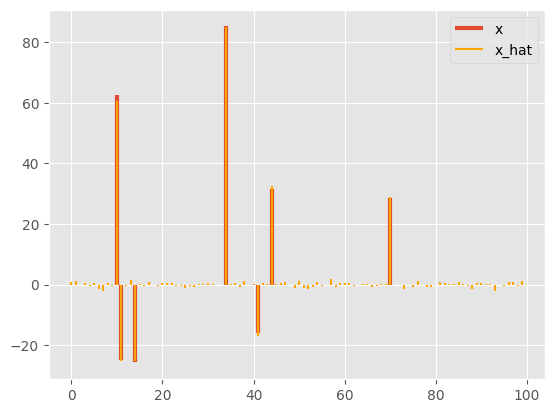

In [36]:
# Here we generate a test vector from our buildDataSet function, put it through the model and look at the output
visualizeReconstruction(discrete_model,max_amplitude,min_sparsity,max_sparsity,vector_size)

### And then we test on the validation data set!

In [37]:
discrete_model_losses = []

dataloader_val, signal_variance = Generate_Dataloader(max_amplitude, min_sparsity, max_sparsity, vector_size, data_set_size)

loss_fn = nn.MSELoss()

# We need to put it in an array for our function to work!
discrete_models = [discrete_model]

normalized_loss, unnormalized_loss = validateModels(dataloader_val,discrete_models,loss_fn)

print(f"Normalized loss is:{normalized_loss}, Unnormalized loss is:{unnormalized_loss}")

Normalized loss is:[0.00676254], Unnormalized loss is:[0.899418]


## Section 5.2: Training range of models for restricted resolution
We have seen that the approach works! For this reason we train a range of models for the restricted resolution. We train for the following setups:

$$SNR \in \{2,5,8,11,14,17,20\}$$
$$IRR \in \{41.09,33.12, 23.53, 17.43, 12.85\}$$
$$M \in \{5, 10, 20, 30, 40, 50\}$$

and a sparsity of $7-9$

### Define discrete model training function
The code works! For this reason we then define a new function which makes the training for this limited resolution neural network much easier. Afterwards we train 19 models, to show our results!

In [38]:
def trainModelsForDiscreteSet(dataloader,SNR_values,imb_percentages,encoding_dims,signal_variance = 133,hidden_dims=[60,80],scale_factor=0.05):
    # Function takes as inputs:
    # dataloader: The dataloader object of the training data set
    # SNR_values: Signal to noise ratios
    # imb_percentages: imbalance percentages
    # encoding_dims: Encoding dimensions
    # signal_variance: The variance of the original signal
    # hidden_dims: Hidden dimensions for the neural network
    # scale_factor: Hyperparameter for the discretization step
    models = []
    discrete_values = np.array([-np.pi, -0.5*np.pi,0,0.5*np.pi,np.pi])
    for model_num,(SNR,imb_percentage,encoding_dim) in enumerate(zip(SNR_values,imb_percentages,encoding_dims)):
        abs_noise_ratio = 10**(SNR/10)
        variance = signal_variance/abs_noise_ratio
        b = 1 - (0.2 * imb_percentage)
        d = imb_percentage * np.pi/8
        hidden_dims = np.array([60,80])
        current_training_model = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
        optimizer = torch.optim.Adam(current_training_model.parameters(), lr=1E-3, betas=(0.9,0.999))
        MSEloss_fn = nn.MSELoss()

        # Training loop
        losses = []
        lowest_loss = float("inf")
        for epoch in range(10000):
            for batch in dataloader:
                inputs, targets = batch  # Unpack the tuple
                optimizer.zero_grad()
                output = current_training_model(inputs)
                qweights = current_training_model.encoder.q_values
                loss = discreteLossPoly(qweights,scale_factor) + MSEloss_fn(output, targets)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
            if loss< lowest_loss:
                lowest_loss = loss
                early_stopping_counter = 0
                best_model = current_training_model
            else:
                early_stopping_counter += 1
                if early_stopping_counter > 100:
                    current_training_model = best_model
                    print(f"Stopped early after {epoch+1} epochs, with loss of {lowest_loss:.6f}")
                    break
            print(f"SNR:{SNR}, Imbalance Percentage:{imb_percentage}, Encoding dimension:{encoding_dim}, Epoch {epoch+1}, Loss: {loss.item():.6f}")
        best_qvalues = best_model.encoder.q_values
        mapped_best_qvalues = mapToDiscreteValues(best_qvalues,discrete_values)
        best_model.encoder.q_values = mapped_best_qvalues
        models.append(best_model)
        losses.append(lowest_loss)
    return models

### Train all the models
Here we train the entire range of models. Notice how we give long lists of SNR,IRR and encoding dims so that it trains in one go.

In [39]:
# Train 19 models. Here we define a list of all combinations of SNR, IRR and encoding dimensions that we want our function to train the models for.
# Uncomment for complete training
# encoding_dims_list = [50, 40, 30, 20, 10, 5, 50, 50, 50, 50,50,50,50,50,50,50,50,50,50]
# SNR_list = [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, 20, 17, 14, 11, 8, 5, 2, np.inf, np.inf,np.inf, np.inf,np.inf, np.inf]
# imb_percentage_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0.04, 0.1, 0.3, 0.6, 1]

# Training just one model for illustration purposes
encoding_dims_list = [30]
SNR_list = [np.inf]
imb_percentage_list = [0]

In [40]:
discrete_models = trainModelsForDiscreteSet(dataloader,SNR_list,imb_percentage_list,encoding_dims_list,scale_factor=0.01)

SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 1, Loss: 402.849609
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 2, Loss: 392.065308
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 3, Loss: 370.107758
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 4, Loss: 347.942261
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 5, Loss: 325.670166
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 6, Loss: 307.111572
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 7, Loss: 287.143768
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 8, Loss: 268.730225
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 9, Loss: 253.841339
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 10, Loss: 237.873260
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 11, Loss: 222.015381
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 12, Loss: 213.047485
SNR:inf, Imba

### Save the models (DO NOT RUN)

In [41]:
# for iter,model in enumerate(discrete_models):
#     torch.save(model.state_dict(),f'Models/discrete_models/discrete_model_SNR{SNR_list[iter]}_IRR{imb_percentage_list[iter]}_enc{encoding_dims_list[iter]}.pt')

### Initialize the pretrained models
Here we initialize our pretrained models

In [42]:
encoding_dims_list = [50, 40, 30, 20, 10, 5, 50, 50, 50, 50,50,50,50,50,50,50,50,50,50]
SNR_list = [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, 20, 17, 14, 11, 8, 5, 2, np.inf, np.inf,np.inf, np.inf,np.inf, np.inf]
imb_percentage_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0.04, 0.1, 0.3, 0.6, 1]

discrete_models = []

for iter,__ in enumerate(SNR_list):
    abs_noise_ratio = 10**(SNR_list[iter]/10)
    variance = signal_variance/abs_noise_ratio
    b = 1 - (0.2 * imb_percentage_list[iter])
    d = imb_percentage_list[iter] * np.pi/8
    hidden_dims = np.array([60,80])
    discrete_models.append(LearnedAutoencoderWithIQImbalance(vector_size,encoding_dims_list[iter],hidden_dims,b,d,variance))
    discrete_models[iter].load_state_dict(torch.load(
        f'Models/discrete_models/discrete_model_SNR{SNR_list[iter]}_IRR{imb_percentage_list[iter]}_enc{encoding_dims_list[iter]}.pt', weights_only=True))

### Validate the models
Here we validate the models using our function. As well as show how the algorithm reconstructs a signal that it has been given! The signal that is reconstructed is for the model with $M = 30, SNR = \infty, IRR = \infty$

In [43]:
loss_fn = nn.MSELoss()
normalized_losses, unnormalized_losses = validateModels(dataloader_val,discrete_models,loss_fn)


/tmp/ipykernel_14740/316903877.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  h_hat = np.array(H_hat.detach())


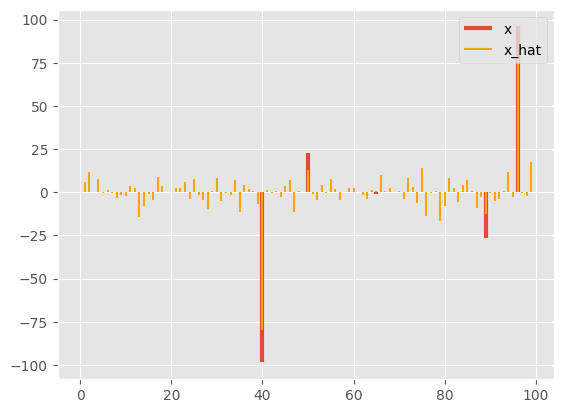

In [44]:
# Corresponding to M = 40, SNR = inf, imb = 0

visualizeReconstruction(discrete_models[2])

## Plotting!

/tmp/ipykernel_14740/1228007042.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  IRR_abs = np.abs(r)**2/np.abs(1-r)**2


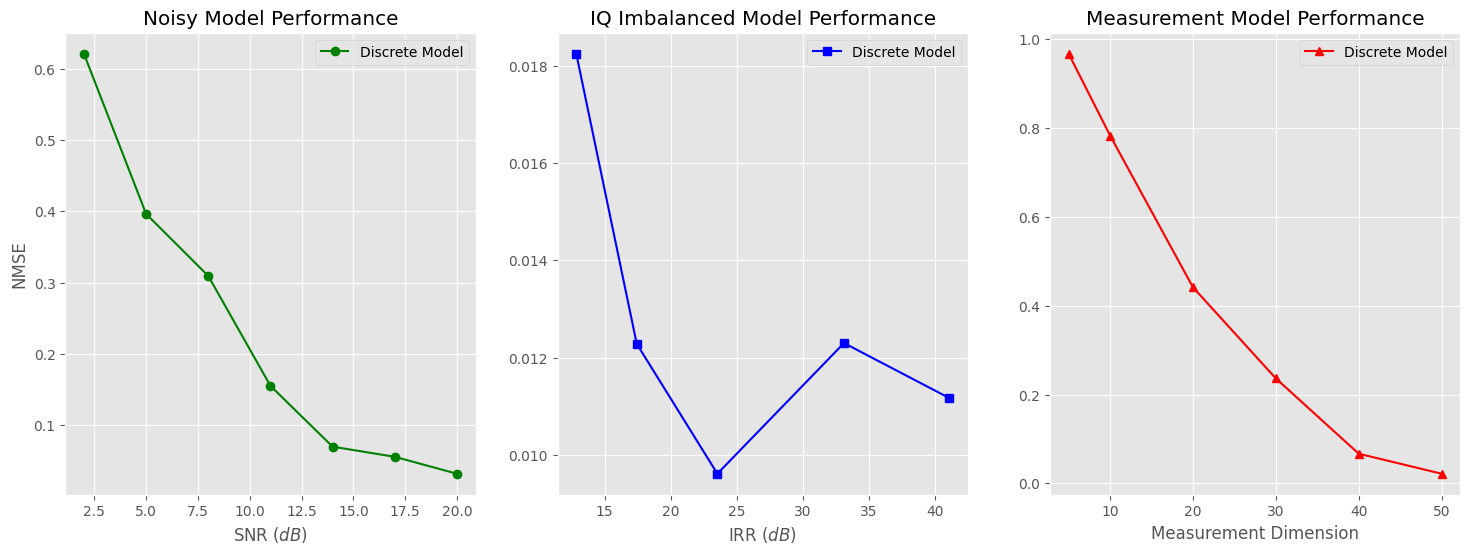

In [45]:
# Quick calculation for the sake of plotting
imb_db_list = []

for perc in imb_percentage_list[13:19]:
    b = 1-0.2*perc
    d = np.pi/8*perc
    r = 0.5*(1+b*np.exp(1j*d))
    IRR_abs = np.abs(r)**2/np.abs(1-r)**2
    imb_db_list.append(10*np.log10(IRR_abs))


plt.style.use('ggplot')
fig1, (ax1, ax2, ax3) = plt.subplots(ncols=3,nrows = 1,figsize=(18, 6))


ax1.plot(SNR_list[6:13], normalized_losses[6:13],marker="o",color="g")
ax2.plot(imb_db_list, normalized_losses[13:20],marker='s',color='b')
ax3.plot(encoding_dims_list[0:6], normalized_losses[0:6],marker='^',color='r')

ax1.set_xlabel("SNR $(dB)$")
ax1.set_ylabel("NMSE")
ax1.set_title("Noisy Model Performance")
ax1.grid(True)
ax1.legend(["Discrete Model"])

ax2.set_xlabel("IRR $(dB)$")
ax2.set_title("IQ Imbalanced Model Performance")
ax2.legend(["Discrete Model"])
ax2.grid(True)

ax3.set_xlabel("Measurement Dimension")
ax3.set_title("Measurement Model Performance")
ax3.legend(["Discrete Model"])
ax3.grid(True)
plt.savefig("Images/discrete_model_performance.pdf", format="pdf", bbox_inches="tight")
plt.show()


# Section 6: Theoretical guarantees
In this section we give some theoretical background. First we calculate the RIC of the models for a sparsity of $s=3$ and then we calculate the coherence of the above restricted encoding matrices.

# Find RIP from Model

In [46]:
import itertools

# Create an array of 100 numbers (0 to 99)
numbers = list(range(100))
RIC = {}

# Generate all possible 3-length combinations
for model in discrete_models:
    max_RIC = 0
    # Get q-values and create the complex matrix W
    qvalues = model.encoder.q_values.data.numpy()
    W = np.e**(1j * qvalues)
    DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
    W = W@DFT
    # Normalize each column so they have unit norm
    col_norms = np.linalg.norm(W, axis=0)
    diag_norm_matrix = np.diag(col_norms)
    W_normalized = W @ np.linalg.inv(diag_norm_matrix)
    
    for combo in itertools.combinations(numbers, 3):
        # Select the columns specified by the combination
        W_cols = W_normalized[:, combo]
        mod_mat = W_cols.T.conj() @ W_cols - np.eye(3)

        # Compute eigenvalues of the Gram matrix
        eig_vals, _ = np.linalg.eig(mod_mat)
        eigenvalues = np.abs(eig_vals)  # They should be real and close to 1
        
        temp_RIC = np.max(eigenvalues)
        
        if temp_RIC > max_RIC:
            max_RIC = temp_RIC

    RIC[model] = max_RIC

KeyboardInterrupt: 

In [41]:
print(RIC.values())

dict_values([np.float64(0.6323692611476529), np.float64(0.7158396081078158), np.float64(0.8445555090481534), np.float64(1.1025568653168647), np.float64(1.347113671520059), np.float64(1.8045370689626752), np.float64(0.6844360230632851), np.float64(0.6321225020698588), np.float64(0.7052236253267463), np.float64(0.6233690657897837), np.float64(0.6244181390930109), np.float64(0.6997250667755308), np.float64(0.667117034147543), np.float64(0.6323692611476529), np.float64(0.7022818482899431), np.float64(0.6319601659228103), np.float64(0.6745933624372249), np.float64(0.6722805584800273), np.float64(0.6306095343526608)])


## Calculate coherences

In [47]:
models = discrete_models

mu = {}
for model in discrete_models:
    qvalues = model.encoder.q_values.data.numpy()
    W = np.e**(1j * qvalues)
    DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
    A = W@DFT
    # Normalize each column so they have unit norm
    col_norms = np.linalg.norm(A, axis=0)
    diag_norm_matrix = np.diag(col_norms)
    A_normalized = A @ np.linalg.inv(diag_norm_matrix)
    A_dotprod = np.abs(A_normalized.conj().T@A_normalized)
    A_no_diag = A_dotprod - np.diag(np.diag(A_dotprod))
    mu[model] = np.max(A_no_diag)

print(mu.values())


dict_values([np.float64(0.39845745250663606), np.float64(0.4559486772115089), np.float64(0.5544156168557605), np.float64(0.642059343642973), np.float64(0.8315236647501129), np.float64(0.9616962994909836), np.float64(0.3798738856807569), np.float64(0.41931210335180485), np.float64(0.4028988449709345), np.float64(0.36634696598330824), np.float64(0.37447066367907095), np.float64(0.40027265395419315), np.float64(0.3861284263583065), np.float64(0.39845745250663606), np.float64(0.47222585803070455), np.float64(0.3973709224115854), np.float64(0.41325483694912335), np.float64(0.424013133218897), np.float64(0.4157523454343733)])


# Section 7: Random IQ, Adversarial Network and Inverting IQ Imbalance

In this section, we create three models. First we simply train the model over a uniform distribution of phase and amplitude imbalance where

$$\phi \in [0,\frac{\pi}{8}], \epsilon \in [0.8,1]$$

denote the phase and amplitude imbalance respectively and are given by $b$ and $d$ in our code.

Following this we train an adversarial network where we train a minmax architecture compactly denoted by 

$$\min_{q,w,b} \max_{\phi, \epsilon} J(q,w,b,\phi,\epsilon,h)$$

where the loss function is again given by

$$J = \frac{1}{N}\lVert h - f(h,w,b,q,\phi,\epsilon) \rVert_2^2 + \lambda g(q)$$

In [ ]:
class LearnedAutoencoderWithVarIQImbalance(nn.Module):
    def __init__(self, input_dim, encoding_dim,hidden_dims,variance,b=1, d=0):
        super(LearnedAutoencoderWithVarIQImbalance, self).__init__()
        self.encoder = ComplexUnitModulus(input_dim,encoding_dim)
        self.encoding_dim = encoding_dim
        self.variance = variance
        self.b = b
        self.d = d
        layers = []
        prev_dim = encoding_dim*2
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim,dim*2))
            layers.append(nn.ReLU())
            prev_dim = dim*2
        self.decoder = nn.Sequential(
            *layers,
            nn.Linear(prev_dim,input_dim*2)
        )

    def forward(self,x):
        encoder_out = self.encoder(x)
        self.r = torch.tensor(0.5*(1+self.b*np.exp(1j*self.d)), dtype=torch.complex64)
        y_real = encoder_out[:, :self.encoding_dim]
        y_imag = encoder_out[:, self.encoding_dim:]
        y = torch.complex(y_real,y_imag)
        yiq = self.r * y + (1-self.r.conj()) * (y.conj())
        yiqr = yiq.real
        yiqi = yiq.imag
        yiqstack = torch.cat((yiqr,yiqi),dim=1)
        noise_np = np.random.normal(0,self.variance,size=self.encoding_dim*2)
        noise_tensor = torch.tensor(noise_np,dtype=torch.float)
        y_iq_stack_noisy = yiqstack + noise_tensor
        return self.decoder(y_iq_stack_noisy)

In [ ]:
# Generate the data
max_amplitude = 100
min_sparsity = 7
max_sparsity = 9
vector_size = 100
data_set_size = 10000

dataloader, signal_variance = Generate_Dataloader(max_amplitude, min_sparsity, max_sparsity, vector_size, data_set_size)

# discrete_values = np.array([-np.pi, -0.5*np.pi,0,0.5*np.pi,np.pi])
scale_factor = 0.01
vector_size = 100
encoding_dim = 50
variance = 0
hidden_dims = np.array([60,80])
current_training_model = LearnedAutoencoderWithVarIQImbalance(vector_size,encoding_dim,hidden_dims,variance)
optimizer = torch.optim.Adam(current_training_model.parameters(), lr=1E-3, betas=(0.9,0.999))
MSEloss_fn = nn.MSELoss()


Epoch 1, Loss: 132.491165
Epoch 2, Loss: 128.054535
Epoch 3, Loss: 122.487267
Epoch 4, Loss: 111.635834
Epoch 5, Loss: 96.261719
Epoch 6, Loss: 87.369499
Epoch 7, Loss: 76.779190
Epoch 8, Loss: 71.133751
Epoch 9, Loss: 66.700722
Epoch 10, Loss: 64.512718
Epoch 11, Loss: 59.962219
Epoch 12, Loss: 56.988033
Epoch 13, Loss: 53.717522
Epoch 14, Loss: 51.146370
Epoch 15, Loss: 50.641869
Epoch 16, Loss: 48.126526
Epoch 17, Loss: 46.690819
Epoch 18, Loss: 45.294880
Epoch 19, Loss: 46.859005
Epoch 20, Loss: 43.956791
Epoch 21, Loss: 45.765968
Epoch 22, Loss: 44.323132
Epoch 23, Loss: 42.538158
Epoch 24, Loss: 40.964336
Epoch 25, Loss: 39.800484
Epoch 26, Loss: 41.640514
Epoch 27, Loss: 39.541737
Epoch 28, Loss: 38.951649
Epoch 29, Loss: 38.225529
Epoch 30, Loss: 38.354515
Epoch 31, Loss: 40.779690
Epoch 32, Loss: 37.561474
Epoch 33, Loss: 35.834244
Epoch 34, Loss: 36.192062
Epoch 35, Loss: 35.891750
Epoch 36, Loss: 35.463524
Epoch 37, Loss: 33.081604
Epoch 38, Loss: 34.448929
Epoch 39, Loss: 3

In [90]:

# Training loop
losses = []
lowest_loss = float("inf")
for epoch in range(10000):
    for batch in dataloader:
        b = np.random.uniform(0.8,1)
        d = np.random.uniform(0,np.pi/8)
        current_training_model.b = b
        current_training_model.d = d
        inputs, targets = batch  # Unpack the tuple
        optimizer.zero_grad()
        output = current_training_model(inputs)
        # qweights = current_training_model.encoder.q_values
        loss = MSEloss_fn(output, targets) # + discreteLossPoly(qweights,scale_factor) 
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if loss< lowest_loss:
        lowest_loss = loss
        early_stopping_counter = 0
        best_model = current_training_model
    else:
        early_stopping_counter += 1
        if early_stopping_counter > 100:
            current_training_model = best_model
            print(f"Stopped early after {epoch+1} epochs, with loss of {lowest_loss:.6f}")
            break
    print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")
# best_qvalues = best_model.encoder.q_values
# mapped_best_qvalues = mapToDiscreteValues(best_qvalues,discrete_values)
# best_model.encoder.q_values = mapped_best_qvalues

Epoch 1, Loss: 7.317043
Epoch 2, Loss: 3.226062
Epoch 3, Loss: 3.508894
Epoch 4, Loss: 3.110212
Epoch 5, Loss: 3.864152
Epoch 6, Loss: 3.140254
Epoch 7, Loss: 6.113074
Epoch 8, Loss: 4.672383
Epoch 9, Loss: 3.868188
Epoch 10, Loss: 2.821302
Epoch 11, Loss: 3.401936
Epoch 12, Loss: 3.542138
Epoch 13, Loss: 2.852451
Epoch 14, Loss: 4.707477
Epoch 15, Loss: 4.289872
Epoch 16, Loss: 4.196852
Epoch 17, Loss: 7.408070
Epoch 18, Loss: 6.191525
Epoch 19, Loss: 5.326628
Epoch 20, Loss: 5.461497
Epoch 21, Loss: 5.576741
Epoch 22, Loss: 4.776458
Epoch 23, Loss: 3.194147
Epoch 24, Loss: 3.171129
Epoch 25, Loss: 6.394760
Epoch 26, Loss: 2.894996
Epoch 27, Loss: 3.148138
Epoch 28, Loss: 4.857862
Epoch 29, Loss: 3.858965
Epoch 30, Loss: 5.288696
Epoch 31, Loss: 5.904537
Epoch 32, Loss: 5.914487
Epoch 33, Loss: 3.366262
Epoch 34, Loss: 3.796346
Epoch 35, Loss: 3.044883
Epoch 36, Loss: 4.714507
Epoch 37, Loss: 2.613925
Epoch 38, Loss: 5.479582
Epoch 39, Loss: 5.769977
Epoch 40, Loss: 4.160508
Epoch 41,

### Save the model
Here we save the model

In [91]:
torch.save(best_model.state_dict(),f'Models/random_imbalanced_models/random_imbalanced_model.pt')

### Load the model


In [92]:
vector_size = 100
encoding_dim = 50
variance = 0
hidden_dims = np.array([60,80])
random_imb_model = LearnedAutoencoderWithVarIQImbalance(vector_size,encoding_dim,hidden_dims,variance)
random_imb_model.load_state_dict(torch.load("Models/random_imbalanced_models/random_imbalanced_model.pt",weights_only=True))

<All keys matched successfully>

### Validating the model

Here we validate the model

In [ ]:
loss_fn = nn.MSELoss()

iq_imbalanced_models = []
imb_percentage_list = [0, 0.04, 0.1, 0.3, 0.6, 1]
IRR_ratios = []
for level in imb_percentage_list:
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    r = 0.5*(1+b*np.exp(1j*d))
    IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)
    IRR_ratios.append(10*np.log10(IRR_ratio))
    random_imb_model.b = b 
    random_imb_model.d = d
    iq_imbalanced_models.append(random_imb_model)
    print(random_imb_model.b)
    print(random_imb_model.d)
    
max_amplitude = 100
min_sparsity = 7
max_sparsity = 9
vector_size = 100
data_set_size = 10000

dataloader_val, signal_variance = Generate_Dataloader(max_amplitude, min_sparsity, max_sparsity, vector_size, data_set_size)

normalized_losses, unnormalized_losses = validateModels(dataloader_val,iq_imbalanced_models,loss_fn)

C:\Users\tomli\AppData\Local\Temp\ipykernel_1808\3766309009.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)


1.0
0.0
0.992
0.015707963267948967
0.98
0.039269908169872414
0.94
0.11780972450961724
0.88
0.23561944901923448
0.8
0.39269908169872414


### Plotting the losses


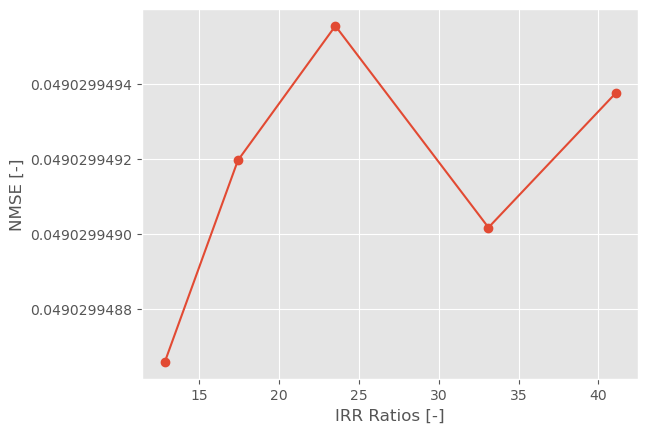

[0.04902995 0.04902995 0.04902995 0.04902995 0.04902995 0.04902995]
[6.52098327 6.52098327 6.52098322 6.52098329 6.52098324 6.52098317]


In [94]:
fig, ax = plt.subplots()
ax.plot(IRR_ratios, normalized_losses, '-o')
ax.set_xlabel('IRR Ratios [-]')
ax.set_ylabel('NMSE [-]')

# Turn off the offset notation
ax.ticklabel_format(useOffset=False, style='plain', axis='y')

plt.show()
print(normalized_losses)
print(unnormalized_losses)

# Section 8: Adversarial Network
Here we train an adversarial network. The adversarial network generates the "worst" IQ imbalance distortion possible. Here we observe what this IQ imbalance is, as well as finding if this improves training.

It should be noted that we must make a new architecture, where we add some layers to "predict" the phase and amplitude imbalance.

In [133]:
class AdversarialNetwork(nn.Module):
    def __init__(self, input_dim, encoding_dim,hidden_dec_dims,hidden_pred_dims,variance):
        super(AdversarialNetwork, self).__init__()
        self.encoder = ComplexUnitModulus(input_dim,encoding_dim)
        self.encoding_dim = encoding_dim
        self.variance = variance
        dec_layers = []
        prev_dim = encoding_dim*2
        for dim in hidden_dec_dims:
            dec_layers.append(nn.Linear(prev_dim,dim*2))
            dec_layers.append(nn.ReLU())
            prev_dim = dim*2
        self.decoder = nn.Sequential(
            *dec_layers,
            nn.Linear(prev_dim,input_dim*2)
        )
        pred_layers = []
        prev_dim = encoding_dim*2
        for dim in hidden_pred_dims:
            pred_layers.append(nn.Linear(prev_dim,dim*2))
            pred_layers.append(nn.ReLU())
            prev_dim = dim*2
        self.predictor = nn.Sequential(
            *pred_layers,
            nn.Linear(prev_dim,2),
        )

    def forward(self,x):
        # Encoder output
        encoder_out = self.encoder(x)

        # Predictor output, we scale the output by our predefined ranges (softmax normalizes between [0,1]) and add bias
        predictor_out = self.predictor(encoder_out) # Size: B x 2 where B is batch size
        b_raw = predictor_out[:,0]
        d_raw = predictor_out[:,1]
        b_tensor = torch.tanh(d_raw)*0.1 + 0.9 # Scale between 0.1 and -0.1 and add bias
        d_tensor = torch.tanh(b_raw)*math.pi/16 + math.pi/16 # We scale it between pi/16 and -pi/16 and then add pi/16
        
        cos_d_tensor = torch.cos(d_tensor)
        sin_d_tensor = torch.sin(d_tensor)
        K1R_tensor = 0.5*(1+b_tensor*cos_d_tensor)
        K1I_tensor = 0.5*b_tensor*sin_d_tensor
        K2R_tensor = 0.5*(1-b_tensor*cos_d_tensor)
        K2I_tensor = 0.5*b_tensor*sin_d_tensor

        # Some nice information about the mean b and d distortion
        self.b_mean = torch.mean(b_tensor)
        self.d_mean = torch.mean(d_tensor)
        
        # Here we add IQ imbalance
        y_real = encoder_out[:, :self.encoding_dim] # Size: B x E where E is encoding dimension
        y_imag = encoder_out[:, self.encoding_dim:] # Size: B x E where E is encoding dimension
        y_IQ_real = (K1R_tensor + K2R_tensor).unsqueeze(1)*y_real + (-K1I_tensor + K2I_tensor).unsqueeze(1)*y_imag
        y_IQ_imag = (K1R_tensor + K2I_tensor).unsqueeze(1)*y_real + (K1R_tensor - K2R_tensor).unsqueeze(1)*y_imag
        y_IQ = torch.cat([y_IQ_real, y_IQ_imag], dim=1)

        # Finally we add noise
        noise = torch.randn_like(y_IQ) * self.variance
        y_IQ_noisy = y_IQ + noise

        # And run the decoder
        return self.decoder(y_IQ_noisy)

### Section 8.2: Training
Here we train the neural network, we swap between maximizing the loss and minimizing the loss

In [134]:
# Generate the data
max_amplitude = 100
min_sparsity = 7
max_sparsity = 9
vector_size = 100
data_set_size = 10000

dataloader, signal_variance = Generate_Dataloader(max_amplitude, min_sparsity, max_sparsity, vector_size, data_set_size)

# Make the model and set two (!) optimizers for the adversarial agent and the autoencoder (S denotes the sensor, and D denotes distorter)
scale_factor = 0.01
vector_size = 100
encoding_dim = 50
variance = 0
hidden_dec_dims = np.array([60,80])
hidden_pred_dims = np.array([50])
model = AdversarialNetwork(vector_size,encoding_dim,hidden_dec_dims,hidden_pred_dims,variance)
optimizerS = torch.optim.Adam([
                {'params': model.encoder.parameters()},
                {'params': model.decoder.parameters()}
            ], lr=1E-3, betas=(0.9,0.999))
optimizerD = torch.optim.Adam(model.predictor.parameters(), lr=1E-3, betas=(0.9,0.999))
MSEloss_fn = nn.MSELoss()

# Training loop
losses_S = []
losses_D = []
lowest_loss = float("inf")
for epoch in range(10000):
    for batch in dataloader:
        inputs, targets = batch  # Unpack the tuple
        output = model(inputs)

        # First optimize the distorter
        optimizerD.zero_grad()
        loss_D = -MSEloss_fn(output,targets)
        loss_D.backward()
        optimizerD.step()
        losses_D.append(loss_D)

        output = model(inputs)
        optimizerS.zero_grad()
        # qweights = current_training_model.encoder.q_values
        
        loss_S = MSEloss_fn(output, targets) # + discreteLossPoly(qweights,scale_factor) 
        loss_S.backward()
        optimizerS.step()
        losses.append(loss.item())
    if loss_S < lowest_loss:
        lowest_loss = loss_S
        early_stopping_counter = 0
        best_model = model
    else:
        early_stopping_counter += 1
        if early_stopping_counter > 100:
            model = best_model
            print(f"Stopped early after {epoch+1} epochs, with loss of {lowest_loss:.6f}")
            break
    print(f"Epoch {epoch+1}, Sensor Loss: {loss_S.item():.6f}, Distorter Loss: {loss_D.item():.6f}, Mean amplitude: {model.b_mean.detach()}, Mean phase: {model.d_mean.detach()}")

Epoch 1, Sensor Loss: 133.891937, Distorter Loss: -133.891083, Mean amplitude: 0.9977265000343323, Mean phase: 0.3916028141975403
Epoch 2, Sensor Loss: 129.971344, Distorter Loss: -129.970886, Mean amplitude: 0.9976873993873596, Mean phase: 0.39224520325660706
Epoch 3, Sensor Loss: 127.424683, Distorter Loss: -127.423592, Mean amplitude: 0.9980652332305908, Mean phase: 0.38891780376434326
Epoch 4, Sensor Loss: 116.331879, Distorter Loss: -116.331810, Mean amplitude: 0.99959397315979, Mean phase: 0.3907410800457001
Epoch 5, Sensor Loss: 107.375259, Distorter Loss: -107.375259, Mean amplitude: 1.0, Mean phase: 0.3911234140396118
Epoch 6, Sensor Loss: 103.333061, Distorter Loss: -103.333061, Mean amplitude: 0.9983959794044495, Mean phase: 0.3911339342594147
Epoch 7, Sensor Loss: 96.150909, Distorter Loss: -96.150902, Mean amplitude: 0.9996001720428467, Mean phase: 0.39035284519195557
Epoch 8, Sensor Loss: 89.496849, Distorter Loss: -89.496773, Mean amplitude: 0.9987266063690186, Mean phas

### Saving the model

In [135]:
enc_adv = best_model.encoder.state_dict()
dec_adv = best_model.decoder.state_dict()
torch.save({
    'encoder':enc_adv,
    'decoder':dec_adv
            },f'Models/adversarial_models/adversarial_model.pt')

### Loading the model

In [136]:
vector_size = 100
encoding_dim = 50
variance = 0
adv_model = LearnedAutoencoderWithVarIQImbalance(vector_size,encoding_dim,hidden_dims,variance)
adv_params = torch.load("Models/adversarial_models/adversarial_model.pt",weights_only=True)
enc_adv = adv_params['encoder']
dec_adv = adv_params['decoder']
adv_model.encoder.load_state_dict(enc_adv)
adv_model.decoder.load_state_dict(dec_adv)


<All keys matched successfully>

### Section 8.3: Evaluation of adversarial network

Here we evaluate the model on a range of IQ imbalances

In [146]:
loss_fn = nn.MSELoss()

adv_models = []
imb_percentage_list = [0, 0.04, 0.1, 0.3, 0.6, 1]
IRR_ratios = []
for level in imb_percentage_list:
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    r = 0.5*(1+b*np.exp(1j*d))
    IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)
    IRR_ratios.append(10*np.log10(IRR_ratio))
    adv_model.b = b 
    adv_model.d = d
    adv_models.append(adv_model)
    print(adv_model.b)
    print(adv_model.d)
    
max_amplitude = 100
min_sparsity = 7
max_sparsity = 9
vector_size = 100
data_set_size = 10000

dataloader_val, signal_variance = Generate_Dataloader(max_amplitude, min_sparsity, max_sparsity, vector_size, data_set_size)

normalized_losses, unnormalized_losses = validateModels(dataloader_val,adv_models,loss_fn)

C:\Users\tomli\AppData\Local\Temp\ipykernel_1808\1432206897.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)


1.0
0.0
0.992
0.015707963267948967
0.98
0.039269908169872414
0.94
0.11780972450961724
0.88
0.23561944901923448
0.8
0.39269908169872414


### Section 8.4: Plotting

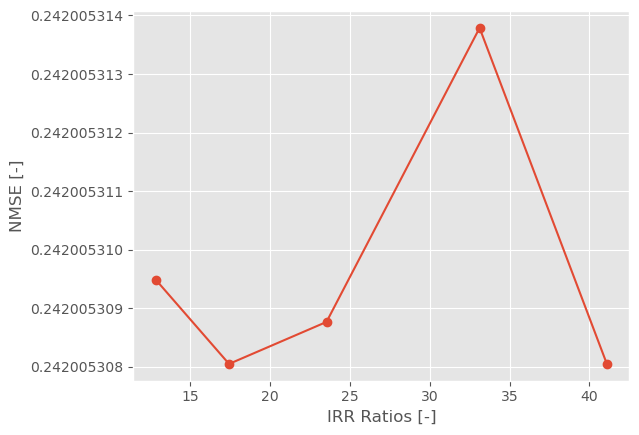

[0.24200531 0.24200531 0.24200531 0.24200531 0.24200531 0.24200531]
[32.18670635 32.18670597 32.18670673 32.18670607 32.18670597 32.18670616]


In [147]:
fig, ax = plt.subplots()
ax.plot(IRR_ratios, normalized_losses, '-o')
ax.set_xlabel('IRR Ratios [-]')
ax.set_ylabel('NMSE [-]')

# Turn off the offset notation
ax.ticklabel_format(useOffset=False, style='plain', axis='y')

plt.show()
print(normalized_losses)
print(unnormalized_losses)

### Section 9: CoSamp


In [21]:
from cosamp import cosamp
import scipy

max_amplitude = 100
min_sparsity = 7
max_sparsity = 9
vector_size = 100
data_set_size = 1

b = 1 - (0.2)
d = np.pi/8
r = torch.tensor(0.5*(1+b*np.exp(1j*d)), dtype=torch.complex64)
variance = 1

dense_data, sparse_data = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size)

In [27]:
y_real = torch.tensor(dense_data.real)
y_imag = torch.tensor(dense_data.imag)
y = torch.complex(y_real,y_imag)
yiq = r * y + (1-r.conj()) * (y.conj())
yiqr = yiq.real
yiqi = yiq.imag
yiqstack = torch.cat((yiqr,yiqi),dim=0).flatten()


In [37]:
p = 103 # random sampling (Note that this is one eighth of the Shannon–Nyquist rate!)
aquis = np.round((vector_size-1) * np.random.rand(p)).astype(int)
y = np.array(yiqstack[aquis]) # our compressed measurement from the random sampling

# Here {y} = [C]{x} = [C][Phi]{s}, where Phi is the inverse discrete cosine transform

Phi = scipy.fft.dct(np.eye(vector_size*2), axis=0, norm='ortho')
CPhi = Phi[aquis,:]
# l1 minimization (through linear programming)
s = cosamp.cosamp(CPhi, y, 10) # obtain the sparse vector through CoSaMP algorithm
xrec = scipy.fft.idct(s, axis=0, norm='ortho') # Reconstructed signal


/tmp/ipykernel_4296/3505468807.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y = np.array(yiqstack[aquis]) # our compressed measurement from the random sampling


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration 77
Iteratio

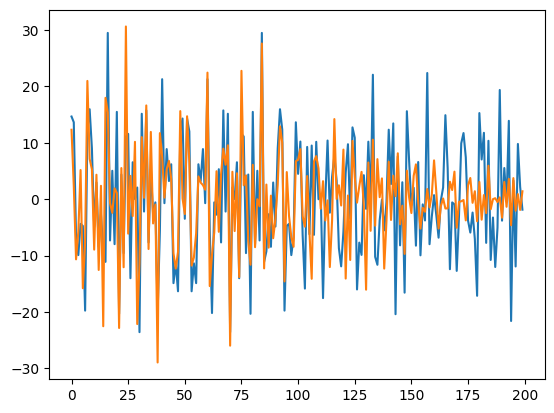

In [38]:
plt.plot(yiqstack)
plt.plot(xrec)
plt.show()